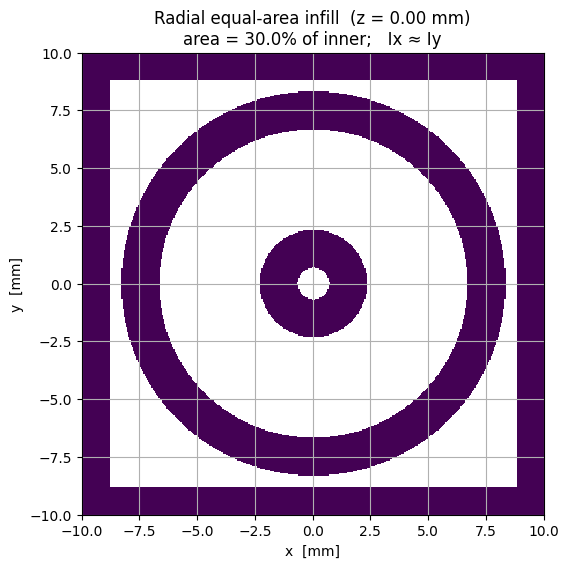

=== Radial equal-area infill ===
Slice @ z              :   0.00 mm
Area fraction (target) :  0.300
Filled area            :  183.617 mm²
Centroid (x̄,ȳ)          : ( -0.00 ,  -0.00) mm
Ix , Iy                : 7617.569 , 7617.569 mm⁴
|Ix − Iy| / Ix          : 1.19e-16
Ixy                    :   -0.000 mm⁴



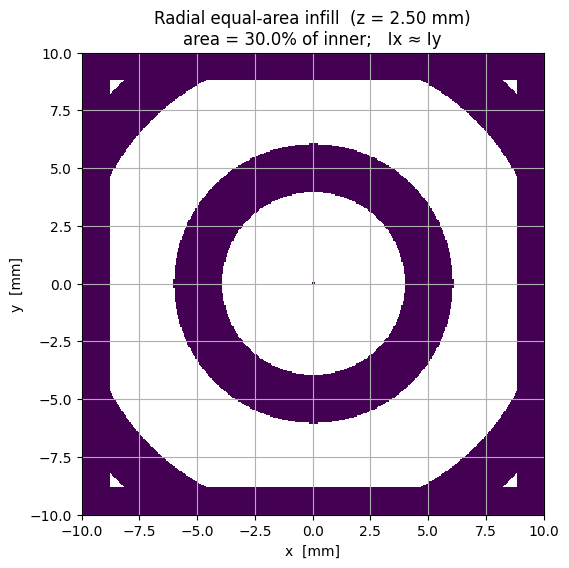

=== Radial equal-area infill ===
Slice @ z              :   2.50 mm
Area fraction (target) :  0.300
Filled area            :  183.637 mm²
Centroid (x̄,ȳ)          : ( -0.00 ,  -0.00) mm
Ix , Iy                : 7825.814 , 7825.814 mm⁴
|Ix − Iy| / Ix          : 0.00e+00
Ixy                    :   -0.000 mm⁴



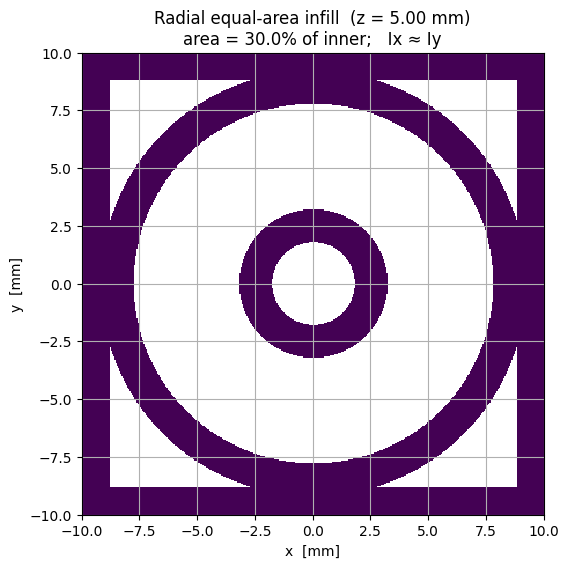

=== Radial equal-area infill ===
Slice @ z              :   5.00 mm
Area fraction (target) :  0.300
Filled area            :  183.637 mm²
Centroid (x̄,ȳ)          : ( -0.00 ,  -0.00) mm
Ix , Iy                : 8009.353 , 8009.353 mm⁴
|Ix − Iy| / Ix          : 0.00e+00
Ixy                    :    0.000 mm⁴



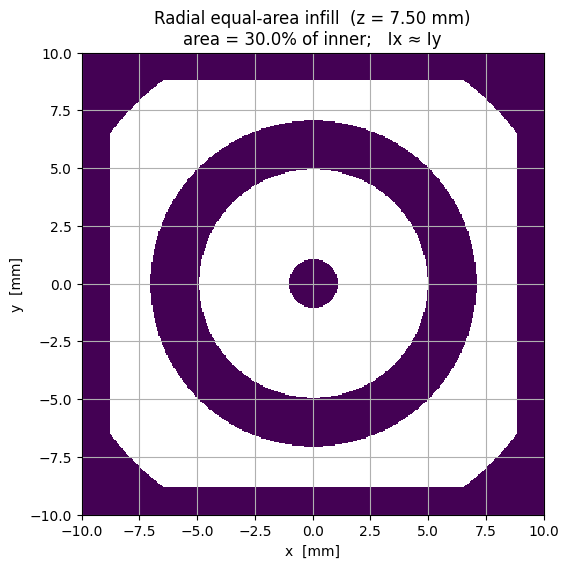

=== Radial equal-area infill ===
Slice @ z              :   7.50 mm
Area fraction (target) :  0.300
Filled area            :  183.587 mm²
Centroid (x̄,ȳ)          : ( -0.00 ,  -0.00) mm
Ix , Iy                : 7516.301 , 7516.301 mm⁴
|Ix − Iy| / Ix          : 0.00e+00
Ixy                    :   -0.000 mm⁴



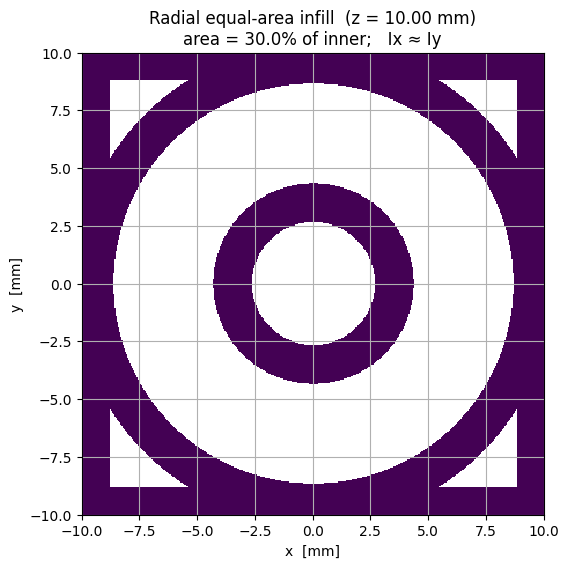

=== Radial equal-area infill ===
Slice @ z              :  10.00 mm
Area fraction (target) :  0.300
Filled area            :  183.647 mm²
Centroid (x̄,ȳ)          : ( -0.00 ,  -0.00) mm
Ix , Iy                : 8084.520 , 8084.520 mm⁴
|Ix − Iy| / Ix          : 1.12e-16
Ixy                    :    0.000 mm⁴



In [1]:
# ----------------------------------------------------------------------
#  NEW  –  isotropic, constant-area implicit surface
# ----------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt


def compute_area_moments(XX, YY, mask):
    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    dA = dx * dy

    A = np.count_nonzero(mask) * dA
    if A == 0:
        return A, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    x_vals = XX[mask]
    y_vals = YY[mask]
    x_c = np.sum(x_vals * dA) / A
    y_c = np.sum(y_vals * dA) / A
    x_shift = x_vals - x_c
    y_shift = y_vals - y_c

    I_x = np.sum((y_shift**2) * dA)
    I_y = np.sum((x_shift**2) * dA)
    I_xy = np.sum((x_shift * y_shift) * dA)
    J = I_x + I_y

    return A, x_c, y_c, I_x, I_y, I_xy, J



def radial_equal_area_infill_rectangular(
    *,
    width,
    height,
    area_fraction,      # 0 … 1  of INNER rectangle that must be solid
    z_height=0.0,
    base_period=6.0,    # radial wavelength  [mm]
    shell_layers=0,
    layer_width=0.4,
    grid_N=400,
    plot=True,
    tol=1e-4,
    max_iter=40
):
    """
    Generates a mask for an r-dependent implicit surface
        f(r,z) = sin( 2π r / base_period + ϕ(z) )
    At each z the threshold is chosen so that:
        • filled area  = area_fraction · inner_area   (constant)
        • Ix ≈ Iy      (radial symmetry → automatic)
    Optional perimeter shells match the style of your gyroid routine.
    """
    # 1) Build XY grid -------------------------------------------------
    xs = np.linspace(-width  / 2,  width  / 2,  grid_N)
    ys = np.linspace(-height / 2,  height / 2,  grid_N)
    XX, YY = np.meshgrid(xs, ys)

    # 2) Implicit field f(r,z) ----------------------------------------
    r   = np.hypot(XX, YY)
    k   = 2.0 * np.pi / base_period
    phi = 2.0 * np.pi * z_height / base_period      # simple upward phase shift
    F   = np.sin(k * r + phi)                       # values in [-1 … 1]

    # 3) Perimeter shells (optional) ----------------------------------
    shell_thk   = shell_layers * layer_width
    inner_w     = width  / 2 - shell_thk
    inner_h     = height / 2 - shell_thk
    inner_mask  = ((np.abs(XX) < inner_w) &
                   (np.abs(YY) < inner_h))
    shell_mask  = ~inner_mask if shell_layers else np.zeros_like(F, bool)

    # 4) Desired filled area in INNER region --------------------------
    A_inner      = inner_w * 2 * inner_h * 2
    target_area  = area_fraction * A_inner

    # 5) Bisection to find threshold t so A == target_area ------------
    lo, hi = F.min(), F.max()
    t = 0.0
    for _ in range(max_iter):
        t = 0.5 * (lo + hi)
        mask_core = (F >= t) & inner_mask
        A, *_ = compute_area_moments(XX, YY, mask_core)
        if abs(A - target_area) < tol * A_inner:
            break
        if A > target_area:
            lo = t
        else:
            hi = t

    core_mask  = (F >= t) & inner_mask
    final_mask = core_mask | shell_mask

    # 6) Section properties ------------------------------------------
    A_tot, x_c, y_c, Ix, Iy, Ixy, J = compute_area_moments(XX, YY, final_mask)

    # 7) Optional plot ------------------------------------------------
    if plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(np.where(final_mask, 1.0, np.nan),
                   origin='lower',
                   extent=[-width / 2, width / 2, -height / 2, height / 2],
                   interpolation='none')
        plt.title(f"Radial equal-area infill  (z = {z_height:.2f} mm)\n"
                  f"area = {area_fraction*100:.1f}% of inner;   Ix ≈ Iy")
        plt.xlabel("x  [mm]")
        plt.ylabel("y  [mm]")
        plt.gca().set_aspect('equal', 'box')
        plt.grid(True)
        plt.show()

    # 8) Console report ----------------------------------------------
    print("=== Radial equal-area infill ===")
    print(f"Slice @ z              : {z_height:6.2f} mm")
    print(f"Area fraction (target) : {area_fraction:6.3f}")
    print(f"Filled area            : {A_tot:8.3f} mm²")
    print(f"Centroid (x̄,ȳ)          : ({x_c:6.2f} , {y_c:6.2f}) mm")
    print(f"Ix , Iy                : {Ix:8.3f} , {Iy:8.3f} mm⁴")
    print(f"|Ix − Iy| / Ix          : {abs(Ix-Iy)/Ix:8.2e}")
    print(f"Ixy                    : {Ixy:8.3f} mm⁴")
    print("")
    return final_mask


# ----------------------------------------------------------------------
#  DEMO: comment or delete after testing
# ----------------------------------------------------------------------
if __name__ == "__main__":
    width         = 20.0          # square coupon 20 × 20 mm
    shell_layers  = 3
    layer_width   = 0.4
    z_values      = np.linspace(0.0, 10.0, 5)     # 5 Z-slices
    area_fraction = 0.30                          # 30 % of inner area

    for z in z_values:
        radial_equal_area_infill_rectangular(
            width=width,
            height=width,
            area_fraction=area_fraction,
            z_height=z,
            shell_layers=shell_layers,
            layer_width=layer_width,
            plot=True
        )


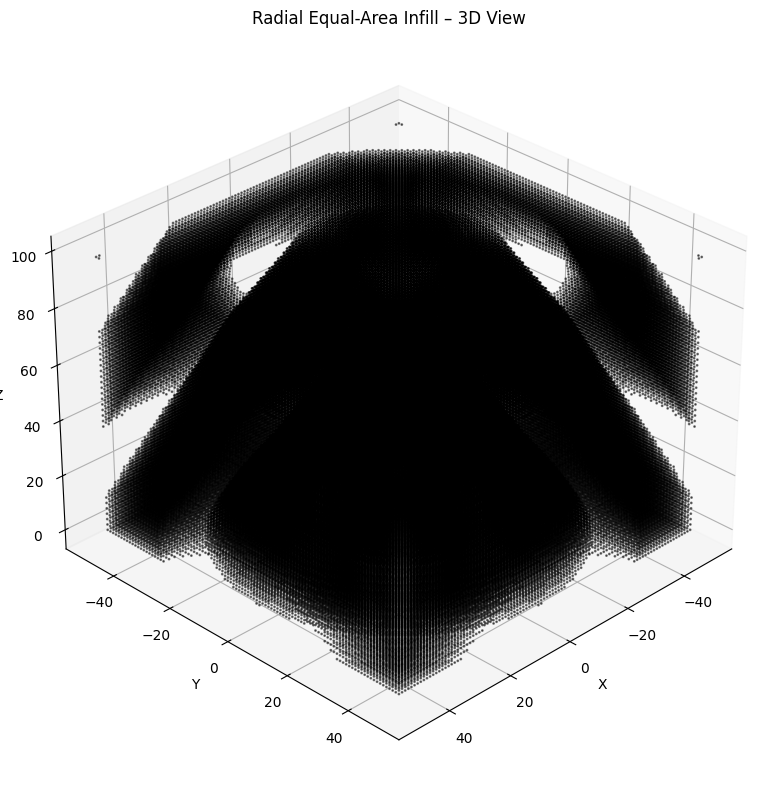

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def generate_radial_equal_area_volume(
    *,
    width=20.0,
    height=20.0,
    thickness=10.0,
    base_period=6.0,
    grid_N=100,
    layer_count=100,
    area_fraction=0.30,
    tol=1e-4,
    max_iter=40
):
    """
    Generates a 3D binary volume of the radial infill pattern
    without perimeter shells. Volume shape: (Z, Y, X)
    """
    xs = np.linspace(-width  / 2, width  / 2, grid_N)
    ys = np.linspace(-height / 2, height / 2, grid_N)
    zs = np.linspace(0.0, thickness, layer_count)
    XX, YY = np.meshgrid(xs, ys)
    r = np.hypot(XX, YY)

    inner_area = width * height
    target_area = area_fraction * inner_area

    filled_volume = []

    for z in zs:
        phi = 2.0 * np.pi * z / base_period
        k = 2.0 * np.pi / base_period
        F = np.sin(k * r + phi)

        # binary search for threshold
        lo, hi = F.min(), F.max()
        for _ in range(max_iter):
            t = 0.5 * (lo + hi)
            mask = (F >= t)
            A = np.count_nonzero(mask) * (width / grid_N) * (height / grid_N)
            if abs(A - target_area) < tol * inner_area:
                break
            if A > target_area:
                lo = t
            else:
                hi = t

        filled_volume.append(mask.astype(np.uint8))

    return np.stack(filled_volume, axis=0)  # shape: (Z, Y, X)


def plot_3d_binary_volume(volume, threshold=0.5, step=2):
    """
    Uses matplotlib to render a 3D surface of the filled voxels.
    """
    z_dim, y_dim, x_dim = volume.shape
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    ax.set_title("Radial Equal-Area Infill – 3D View")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    ax.view_init(elev=30, azim=45)

    for z in range(0, z_dim, step):
        mask = volume[z]
        y_idx, x_idx = np.nonzero(mask)
        x = x_idx - x_dim / 2
        y = y_idx - y_dim / 2
        z_layer = np.full_like(x, z)
        ax.scatter(x, y, z_layer, color='black', s=1, alpha=0.5)

    plt.tight_layout()
    plt.show()


# -------------------------------
# Run the 3D visualization
# -------------------------------
if __name__ == "__main__":
    volume = generate_radial_equal_area_volume(
        width=20.0,
        height=20.0,
        thickness=10.0,
        base_period=6.0,
        area_fraction=0.60,
        grid_N=100,
        layer_count=100
    )

    plot_3d_binary_volume(volume)
